In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import tensorflow as tf
from tensorflow.python.ops import math_ops
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras import regularizers
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from scipy import ndimage as ndi

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("Data/training.zip")

In [4]:
df["Image"] = df.apply(lambda row: np.asarray([int(i) for i in row["Image"].split()]).astype('float32'),axis=1)  

In [5]:
#Global variable of columns used in several of the methods below

cols = df.columns.tolist()

# Exploratory Data Analysis

In [6]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,"[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 239..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,"[219.0, 215.0, 204.0, 196.0, 204.0, 211.0, 212..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,"[144.0, 142.0, 159.0, 180.0, 188.0, 188.0, 184..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,"[193.0, 192.0, 193.0, 194.0, 194.0, 194.0, 193..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,"[147.0, 148.0, 160.0, 196.0, 215.0, 214.0, 216..."


In [7]:
#Obtaining markeer coordinates from data frame

def marker_coords(df,k):
    l = list(df.columns)
    x = []
    y = []
    for i in l:
        if i[-1]=="x":
            x.append(df[i][k])
        if i[-1]=="y":
            y.append(df[i][k])
    return x,y

In [8]:
#Picture of face in row k with markers

def get_face(k):
    arr = np.array(df["Image"][k]).reshape(96,96)
    fig, ax = plt.subplots()
    sns.heatmap(arr,cmap="gray", cbar=False,xticklabels=False,yticklabels=False, ax=ax)
    x,y = marker_coords(df,k)
    sns.scatterplot(x = x, y = y,ax=ax)

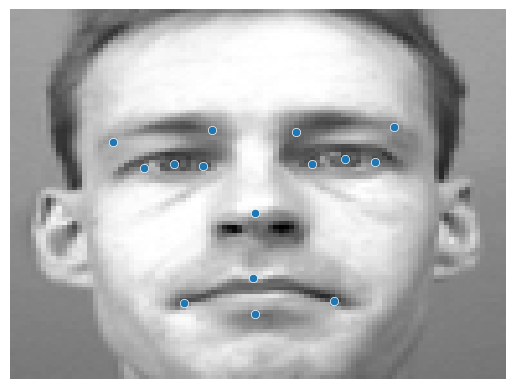

In [9]:
get_face(302)

In [10]:
#Set of kyepoints

keypoints = set()
for col in cols[:-1]:
    keypoints.add(col[:-2])
keypoints

{'left_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'mouth_center_bottom_lip',
 'mouth_center_top_lip',
 'mouth_left_corner',
 'mouth_right_corner',
 'nose_tip',
 'right_eye_center',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end'}

In [11]:
df.iloc[6200]

left_eye_center_x                                                    65.834096
left_eye_center_y                                                    37.999639
right_eye_center_x                                                   36.749246
right_eye_center_y                                                   31.767211
left_eye_inner_corner_x                                                    NaN
left_eye_inner_corner_y                                                    NaN
left_eye_outer_corner_x                                                    NaN
left_eye_outer_corner_y                                                    NaN
right_eye_inner_corner_x                                                   NaN
right_eye_inner_corner_y                                                   NaN
right_eye_outer_corner_x                                                   NaN
right_eye_outer_corner_y                                                   NaN
left_eyebrow_inner_end_x                            

(array([2.140e+03, 0.000e+00, 8.700e+01, 0.000e+00, 0.000e+00, 2.800e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00, 8.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 4.755e+03, 0.000e+00,
        1.000e+01]),
 array([ 0.        ,  0.77419355,  1.5483871 ,  2.32258065,  3.09677419,
         3.87096774,  4.64516129,  5.41935484,  6.19354839,  6.96774194,
         7.74193548,  8.51612903,  9.29032258, 10.06451613, 10.83870968,
        11.61290323, 12.38709677, 13.16129032, 13.93548387, 14.70967742,
        15.48387097, 16.25806452, 17.03225806, 17.80645161, 18.58064516,
        19.35483871, 20.12903226, 20.90322581, 21.67741935, 22.4516129 ,
        23.22580645, 24.        ]),
 <BarContainer object of 31 artists>)

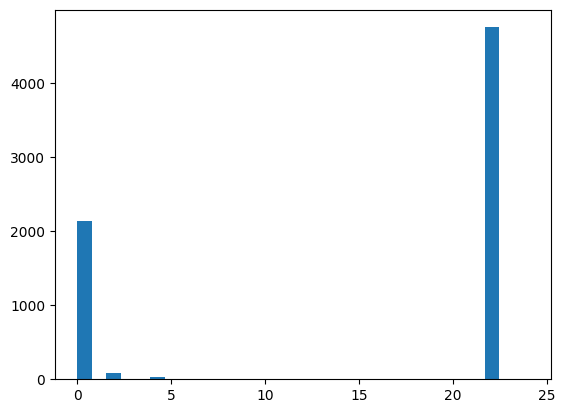

In [12]:
#Number of rows with x NaNs

number_nans = df.isna().sum(axis=1)
plt.hist(number_nans,bins=31)

In [13]:
#Number NaNs in each column

d = {}
for key in keypoints:
    n = df[key+"_x"].isna().sum()
    print(key + " has " + str(n) + " NaNs")

right_eye_center has 13 NaNs
left_eyebrow_inner_end has 4779 NaNs
nose_tip has 0 NaNs
mouth_center_top_lip has 4774 NaNs
mouth_center_bottom_lip has 33 NaNs
mouth_right_corner has 4779 NaNs
mouth_left_corner has 4780 NaNs
left_eye_inner_corner has 4778 NaNs
left_eye_outer_corner has 4782 NaNs
right_eye_outer_corner has 4781 NaNs
right_eye_inner_corner has 4781 NaNs
right_eyebrow_outer_end has 4813 NaNs
right_eyebrow_inner_end has 4779 NaNs
left_eyebrow_outer_end has 4824 NaNs
left_eye_center has 10 NaNs


In [14]:
#Set of columns with few NaNs

rich_cols=[]
for key in keypoints:
    if df[key+"_x"].isna().sum() < 40:
        rich_cols += [key+"_x",key+"_y"]
rich_cols

['right_eye_center_x',
 'right_eye_center_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y',
 'left_eye_center_x',
 'left_eye_center_y']

### Heatmaps for each facial keypoint

In [15]:
#Dataframe with the 4 keypoints with few NaNs

df_4k = df[rich_cols+["Image"]].dropna()

In [16]:
#Dataframe without NaNs in any keypoint

df_15k = df.dropna()
df_15k

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,"[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 239..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,"[219.0, 215.0, 204.0, 196.0, 204.0, 211.0, 212..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,"[144.0, 142.0, 159.0, 180.0, 188.0, 188.0, 184..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,"[193.0, 192.0, 193.0, 194.0, 194.0, 194.0, 193..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,"[147.0, 148.0, 160.0, 196.0, 215.0, 214.0, 216..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,"[191.0, 191.0, 191.0, 190.0, 189.0, 185.0, 184..."
2278,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,"[19.0, 19.0, 19.0, 18.0, 13.0, 7.0, 3.0, 4.0, ..."
2281,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,"[31.0, 40.0, 47.0, 31.0, 54.0, 58.0, 63.0, 100..."
2282,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,"[7.0, 1.0, 5.0, 1.0, 3.0, 20.0, 12.0, 0.0, 5.0..."


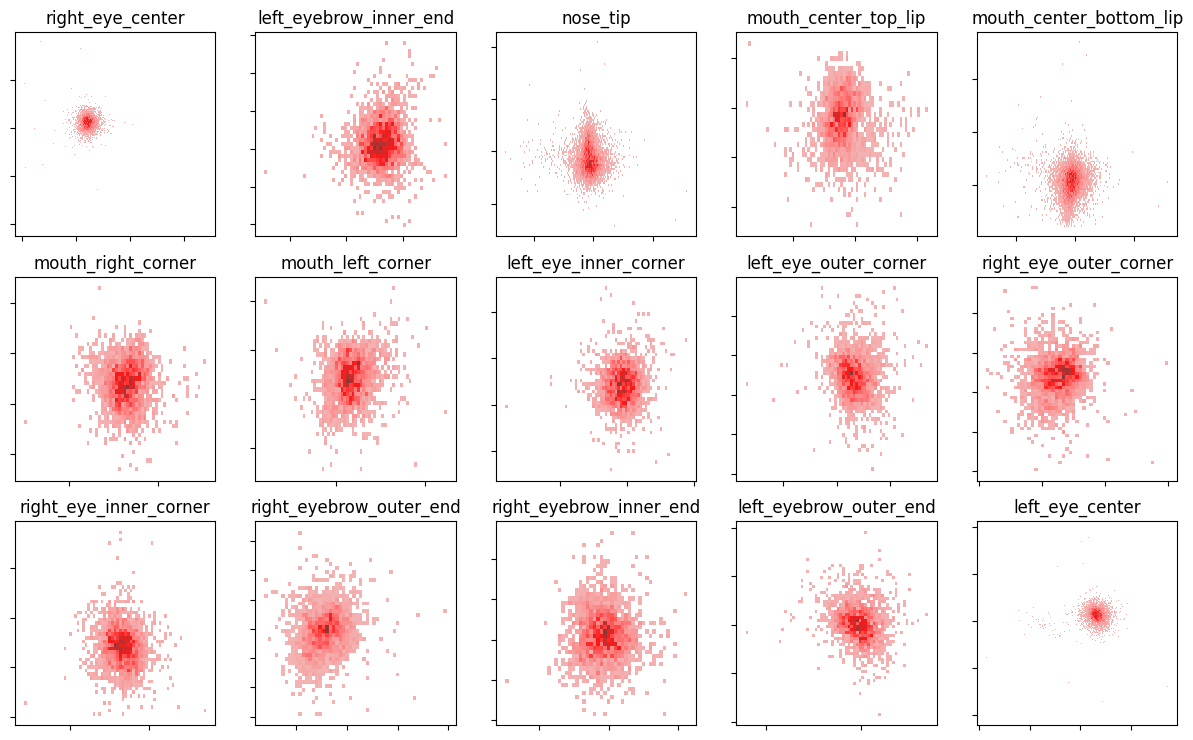

In [17]:
#Heatmaps of the keypoints

fig, ax = plt.subplots(3,5, figsize=(15, 9))
n = 0
for key in keypoints:
    xlabel = key + '_x'
    ylabel = key + '_y'
    i= int(n/5)
    j= n%5
    if xlabel in rich_cols:
        plot = sns.histplot(data=df_4k, x=xlabel, y=ylabel, color="red",cbar=False,ax=ax[i,j])
    else:
        plot = sns.histplot(data=df_15k, x=xlabel, y=ylabel, color="red",cbar=False,ax=ax[i,j])
    plot.set(xticklabels=[],yticklabels=[],xlabel=None,ylabel=None,title=key)
    plot.invert_yaxis()
    n+=1

# Data Augmentation

## Horizontal reflection

We reflect all images horizontally. The labels of face markers containing left / right are swapped accordingly

In [18]:
#Dictionary swapping left and right labels of markers
cols = list(df.columns)
d_swap = {}
for col in cols:
    if col[0:4]=="left":
        d_swap.update({col:"right" + col[4:]})
    elif col[0:5]=="right":
        d_swap.update({col:"left" + col[5:]})
    elif col[0:10]=="mouth_left":
        d_swap.update({col:"mouth_right" + col[10:]})
    elif col[0:11]=="mouth_right":
        d_swap.update({col:"mouth_left" + col[11:]})
    else:
        d_swap.update({col:col})
d_swap

{'left_eye_center_x': 'right_eye_center_x',
 'left_eye_center_y': 'right_eye_center_y',
 'right_eye_center_x': 'left_eye_center_x',
 'right_eye_center_y': 'left_eye_center_y',
 'left_eye_inner_corner_x': 'right_eye_inner_corner_x',
 'left_eye_inner_corner_y': 'right_eye_inner_corner_y',
 'left_eye_outer_corner_x': 'right_eye_outer_corner_x',
 'left_eye_outer_corner_y': 'right_eye_outer_corner_y',
 'right_eye_inner_corner_x': 'left_eye_inner_corner_x',
 'right_eye_inner_corner_y': 'left_eye_inner_corner_y',
 'right_eye_outer_corner_x': 'left_eye_outer_corner_x',
 'right_eye_outer_corner_y': 'left_eye_outer_corner_y',
 'left_eyebrow_inner_end_x': 'right_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y': 'right_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x': 'right_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y': 'right_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x': 'left_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y': 'left_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x'

In [19]:
# Reflect images and markers horizontally

#Map of giving the corresponding coordinates of an image vector when reflected hhorizontally
def x_ref(a):
    return 95+a-2*(a % 96)

#Reflects an image by x
def reflect_x(Image):
    l = [int(i) for i in Image]
    reflected_image = np.zeros(96*96)
    for i in range(len(l)):
        reflected_image[x_ref(i)] = l[i]
    return reflected_image

#Builds the reflected dataframe
def df_reflections(df):
    df_reflected = pd.DataFrame(columns = df.columns)
    df_reflected["Image"] = df.apply(lambda row : reflect_x(row["Image"]),axis=1)
    cols = list(df.columns)
    for col in cols:
        if col[-1]=="x":
            df_reflected[d_swap[col]] = df.apply(lambda row : 96-row[col],axis=1)
        if col[-1]=="y":
            df_reflected[d_swap[col]] = df.apply(lambda row : row[col],axis=1)
    return df_reflected
dfr = df_reflections(df)
dfr.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,65.772992,36.421678,29.966436,39.002274,59.643429,37.389402,72.547128,37.389402,36.417925,39.647423,...,57.066803,67.385504,77.388992,34.804692,79.970165,52.687398,72.935459,52.869293,84.485774,"[250.0, 250.0, 250.0, 251.0, 248.0, 250.0, 252..."
1,66.050723,33.448715,31.667064,34.970077,59.965277,34.361532,71.527489,33.144443,37.143830,35.274349,...,55.660936,60.877617,76.047660,39.578553,76.352000,49.315404,70.266553,50.532085,85.480170,"[84.0, 88.0, 92.0, 93.0, 96.0, 97.0, 100.0, 10..."
2,65.096211,34.909642,30.942947,34.909642,58.321895,36.320968,71.023579,36.603221,36.588000,36.320968,...,53.538947,62.273684,72.732000,35.177053,73.014316,48.725053,70.191789,48.725053,78.659368,"[207.0, 207.0, 208.0, 207.0, 207.0, 208.0, 213..."
3,63.976904,37.261774,30.774261,37.261774,58.381357,38.754115,70.692730,38.007903,35.996661,39.127179,...,54.166539,58.754504,74.195478,30.401113,72.703722,45.696835,70.091687,44.438817,78.268383,"[202.0, 199.0, 199.0, 197.0, 196.0, 196.0, 195..."
4,63.755190,38.042032,29.274699,39.621261,59.017620,39.094852,73.493890,38.305237,37.434110,39.621261,...,64.889521,64.808245,76.997301,35.328589,77.523239,51.037252,73.707387,51.772859,86.871166,"[213.0, 192.0, 151.0, 119.0, 111.0, 94.0, 86.0..."


<Axes: >

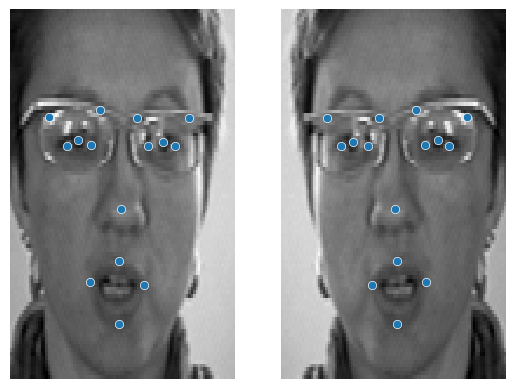

In [20]:
k = 10
#l = [int(i) for i in df["Image"][k]]
arr = np.array(df["Image"][k]).reshape(96,96)
arr2 = np.array(dfr["Image"][k]).reshape(96,96)
fig, ax = plt.subplots(1,2)
sns.heatmap(arr,cmap="gray", cbar=False,xticklabels=False,yticklabels=False, ax=ax[0])
x,y = marker_coords(df,k)
sns.scatterplot(x = x, y = y,ax=ax[0])
sns.heatmap(arr2,cmap="gray", cbar=False,xticklabels=False,yticklabels=False, ax=ax[1])
x,y = marker_coords(dfr,k)
sns.scatterplot(x = x, y = y,ax=ax[1])

## Random perturbation

We augment the data by applying a random affine transformation to the image. The coefficients of the affine transformatioinn are normally distributed with standard deviation sigma (hyperparameter) and centered at the identity transformation. 

In [21]:
#Asks if a vector is insde the bounds of the image
def inside_bounds(v):
    return (v[0]>=0)&(v[1]>=0)&(v[0]<96)&(v[1]<96)

In [22]:
def randomize_image(img,markers,sigma):
    s = np.random.normal(0, sigma, 6) #Sample 6 random numbers
    A = np.array([[1,0,0]+s[:3],[0,1,0]+s[-3:],[0,0,1]]) #Random affine transformation matrix
    Ainv = np.linalg.inv(A)
    pimg = ndi.affine_transform(img, Ainv) #Transform image by A
    markers = np.vstack([markers, np.ones((1, 15),)])   
    pm = A.dot(markers) #Tramsform makers by A
    pm = pm[:2, :]
    values=[]
    for i in range(15):
        if inside_bounds(pm[:,i]) == False:
            pm[:,i] = [np.nan,np.nan]
        values = values + [pm[1,i],pm[0,i]]
    values = values + [pimg.flatten()]
    return values

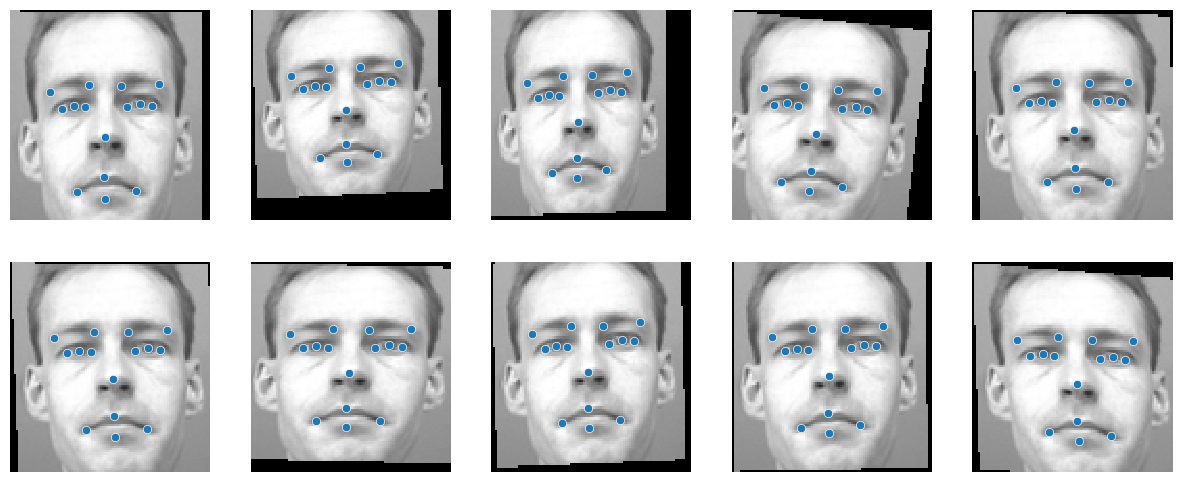

In [23]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
df_rand = pd.DataFrame()

k = 302
sigma = 0.05
row = df.iloc[k]

for i in range(2):
    for j in range(5):
        RI = randomize_image(np.array(row["Image"]).reshape(96,96), 
                         np.array([[row[cols[2*i+1]],row[cols[2*i]]] for i in range(15)]).transpose(), 
                         sigma)
        df_rand= pd.DataFrame([RI], columns=cols)
        arr = np.array(df_rand["Image"][0]).reshape(96,96)
        sns.heatmap(arr,cmap="gray", cbar=False,xticklabels=False,yticklabels=False, ax=ax[i,j])
        x,y = marker_coords(df_rand,0)
        sns.scatterplot(x = x, y = y,ax=ax[i,j])


In [24]:
#Function adding perturbation of images.
#sigma = standard deviation of affine transformation coefficients
#n_samples = number of extra images per image in the original dataframe

def add_distorted_images(df, sigma, n_samples):
    df_arrays  = pd.DataFrame()
    df_arrays["X"] = df.apply(lambda row: np.array(row["Image"]).reshape(96,96)  ,axis=1)
    df_arrays["Y"] = df.apply(lambda row: np.array([[row[cols[2*i+1]],row[cols[2*i]]] for i in range(15)]).transpose(),axis=1)
    if n_samples < 1:
        unused, used = train_test_split(df_arrays, test_size=n_samples)
        RI = used.apply(lambda row: randomize_image(row["X"],row["Y"],sigma),axis=1)
    else:
        RI = df_arrays.apply(lambda row: randomize_image(row["X"],row["Y"],sigma),axis=1)
        for i in range(int(n_samples-1)):
            RI = pd.concat([RI,df_arrays.apply(lambda row: randomize_image(row["X"],row["Y"],sigma),axis=1)],ignore_index=True)
    df_rand = pd.DataFrame()
    for i in range(31):
        df_rand[cols[i]]= RI.apply(lambda x: x[i])
    augmented_df = pd.concat([df,df_rand],ignore_index=True)
    return augmented_df

# Data preprocessing

In [25]:
## Data normalization function

def data_preprocess(df):
    X = df["Image"]/256
    X = X.apply(lambda x: x.reshape(96,96))
    X = np.asarray(X.to_list()).astype('float32')
    Y = df.drop("Image",axis=1)
    Y = Y/96
    return X,Y

# Model architecture

In [26]:
#Custom loss function dealing with nans

def lossf(y_true,y_pred):
    y_true = tf.where(tf.math.is_nan(y_true), y_pred, y_true)
    return tf.keras.losses.MSE(y_true,y_pred)


In [27]:
def FKmodel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.LocallyConnected2D(32, (3, 3),activation='relu'))
    #model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.LocallyConnected2D(128, (3, 3),activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
    #model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Flatten())
    model.add(Dropout(0.1))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(30, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss=lossf)
    return model

In [28]:
model = FKmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

# Data augmentation hyperparameters grid search

Grid search for data augmentation hyperparamenters, number of randomly perturbed images and variance, for the model with 15 keypoints.

Test loss for sigma = 0.03 and n_samples = 4 is loss = 0.00026971843908540905
Test loss for sigma = 0.03 and n_samples = 6 is loss = 0.0002657617151271552
Test loss for sigma = 0.03 and n_samples = 7 is loss = 0.00026254745898768306
Test loss for sigma = 0.03 and n_samples = 8 is loss = 0.0002764392993412912
Test loss for sigma = 0.03 and n_samples = 9 is loss = 0.0002665083738975227
Test loss for sigma = 0.04 and n_samples = 4 is loss = 0.00026736067957244813
Test loss for sigma = 0.04 and n_samples = 6 is loss = 0.0002667380904313177
Test loss for sigma = 0.04 and n_samples = 7 is loss = 0.0002623662876430899
Test loss for sigma = 0.04 and n_samples = 8 is loss = 0.00025709564215503633
Test loss for sigma = 0.04 and n_samples = 9 is loss = 0.0002713106223382056
Test loss for sigma = 0.05 and n_samples = 4 is loss = 0.0002644461637828499
Test loss for sigma = 0.05 and n_samples = 6 is loss = 0.0002663833147380501
Test loss for sigma = 0.05 and n_samples = 7 is loss = 0.000261912355199

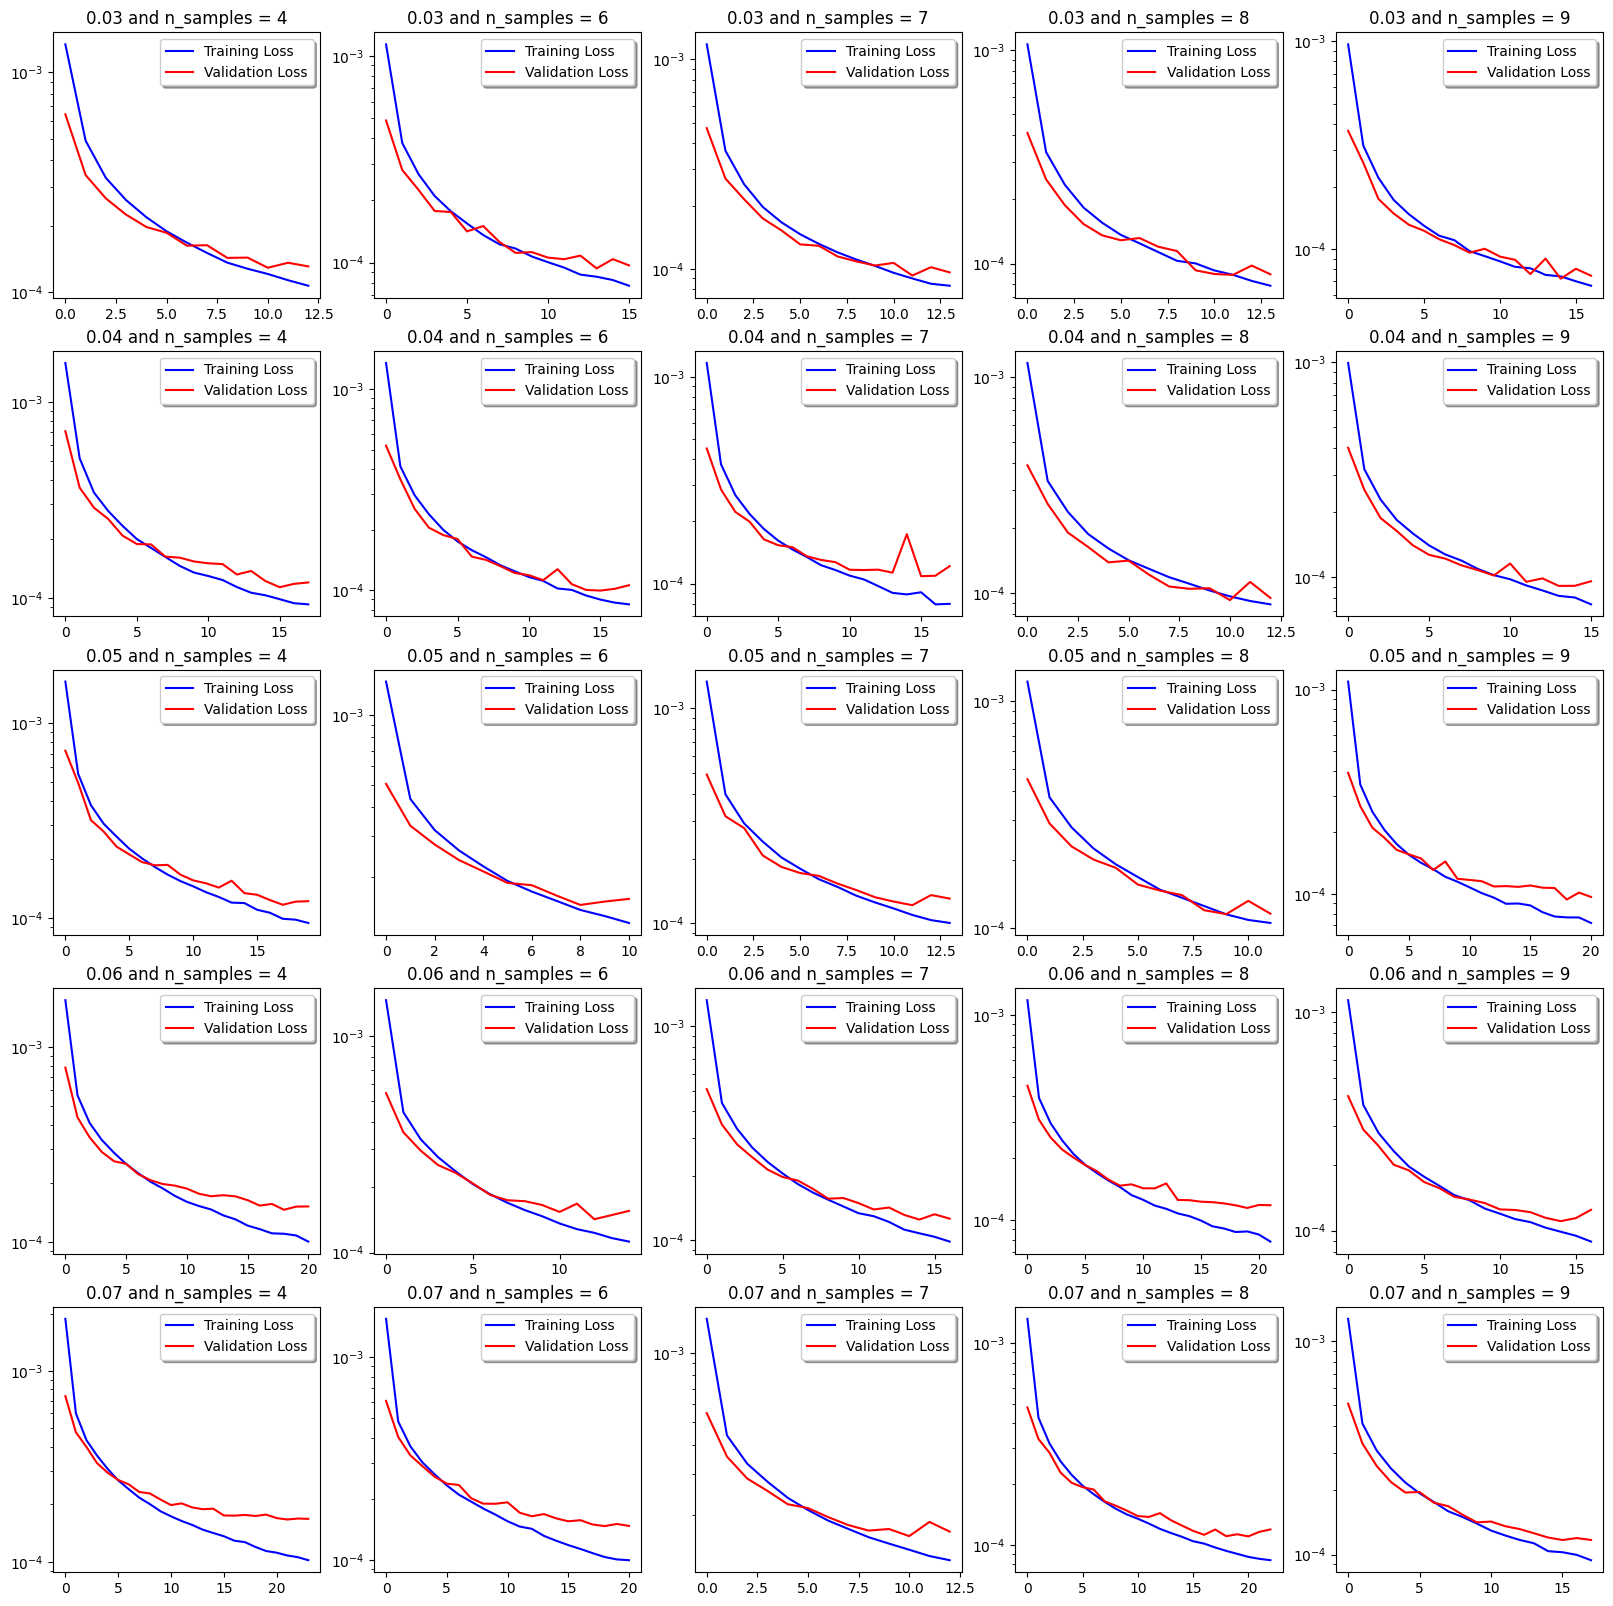

In [51]:
#Splitting the data before augmentation
train, test = train_test_split(df, test_size=0.1)
X_test, Y_test = data_preprocess(test)

#Preparing plots
fig, ax = plt.subplots(5,5, figsize=(20, 20))

#Setting up a dataframe to record losses for test data
losses_df = pd.DataFrame()

#Allowed values of sigma
sigma_values = [0.03,0.04,0.05,0.06,0.07]
n_values = [4,6,7,8,9]
for i in range(5):
    sigma = sigma_values[i]
    loss_row = {"sigma" : sigma}
    for j in range(5):
        n_samples = n_values[j]
        augmented_df = add_distorted_images(train, sigma, n_samples)
        X,Y = data_preprocess(augmented_df)
        model = FKmodel()
        history = model.fit(X, Y,
                    batch_size=48,
                    epochs=60,
                    validation_split=0.1,
                    callbacks=EarlyStopping(monitor="val_loss", patience=2),
                    verbose=0)
        test_loss = model.evaluate(X_test, Y_test,verbose=0)
        loss_row.update({str(n_samples):test_loss})
        print("Test loss for sigma = " + str(sigma) + " and n_samples = " + str(n_samples) + " is loss = " + str(test_loss))
        ax[i,j].set_yscale('log')
        ax[i,j].title.set_text(str(sigma) + " and n_samples = " + str(n_samples))
        ax[i,j].plot(history.history['loss'], color='b', label="Training Loss",axes =ax[i,j])
        ax[i,j].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[i,j])
        legend = ax[i,j].legend(loc='best', shadow=True)
    loss_row = pd.DataFrame(loss_row,index =[i])
    losses_df = pd.concat([losses_df,loss_row])

In [52]:
losses_df

,sigma,4,6,7,8,9
0,0.03,0.000270,0.000266,0.000263,0.000276,0.000267
1,0.04,0.000267,0.000267,0.000262,0.000257,0.000271
2,0.05,0.000264,0.000266,0.000262,0.000258,0.000274
3,0.06,0.000269,0.000265,0.000260,0.000248,0.000266
4,0.07,0.000269,0.000249,0.000262,0.000237,0.000248


# Model training

In [29]:
#Splitting the data

train, test = train_test_split(df, test_size=0.1)

In [30]:
#Augmenting the data
dfr = pd.concat([df_reflections(train),train])
df_augmented = add_distorted_images(dfr, 0.075, 8)


In [31]:
model = FKmodel()

X_train,Y_train = data_preprocess(df_augmented)
history = model.fit(X_train, Y_train,
                    batch_size=48,
                    epochs=60,
                    validation_split=0.1,
                    callbacks=EarlyStopping(monitor="val_loss", patience=3))

Epoch 1/60
2142/2142 [==============================] - 27s 9ms/step - loss: 9.0928e-04 - val_loss: 4.5004e-04
Epoch 2/60
2142/2142 [==============================] - 18s 8ms/step - loss: 3.5444e-04 - val_loss: 2.7508e-04
Epoch 3/60
2142/2142 [==============================] - 18s 8ms/step - loss: 2.7067e-04 - val_loss: 2.3919e-04
Epoch 4/60
2142/2142 [==============================] - 18s 8ms/step - loss: 2.2804e-04 - val_loss: 2.0485e-04
Epoch 5/60
2142/2142 [==============================] - 17s 8ms/step - loss: 2.0158e-04 - val_loss: 1.8636e-04
Epoch 6/60
2142/2142 [==============================] - 17s 8ms/step - loss: 1.8331e-04 - val_loss: 1.7902e-04
Epoch 7/60
2142/2142 [==============================] - 18s 8ms/step - loss: 1.7075e-04 - val_loss: 1.6757e-04
Epoch 8/60
2142/2142 [==============================] - 18s 8ms/step - loss: 1.5971e-04 - val_loss: 1.7920e-04
Epoch 9/60
2142/2142 [==============================] - 17s 8ms/step - loss: 1.5076e-04 - val_loss: 1.6089e-04
E

# Model Results

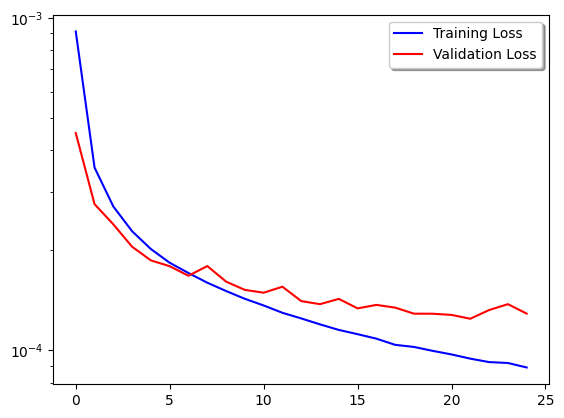

In [32]:
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.plot(history.history['loss'], color='b', label="Training Loss")
ax.plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax)
legend = ax.legend(loc='best', shadow=True)

In [33]:
X_test, Y_test = data_preprocess(test)
test_loss = model.evaluate(X_test, Y_test)

23/23 [==============================] - 0s 4ms/step - loss: 1.2222e-04


In [34]:
#Test dataframe

df_test = pd.read_csv("Pyt/Face Detection/Data/test.zip")

#Prepare data for prediction
TestImages = df_test["Image"]
TestImages = TestImages.apply(lambda x: np.array([int(i)/256 for i in x.split()]).reshape(96,96))
TestImages= np.asarray(TestImages.to_list()).astype('float32')

In [35]:
Results = model.predict(TestImages)

56/56 [==============================] - 1s 8ms/step


In [36]:
#Picture of face with predicted markers

def predict_face(k):
    coords = Results[k]*96
    arr = TestImages[k]*256
    fig, ax = plt.subplots()
    sns.heatmap(arr,cmap="gray", cbar=False,xticklabels=False,yticklabels=False, ax=ax)
    sns.scatterplot(x = coords[::2], y = coords[1::2],ax=ax)

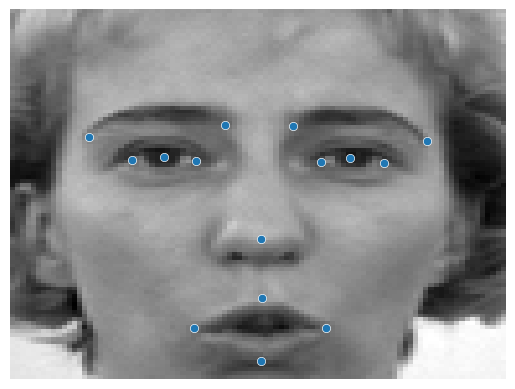

In [37]:
predict_face(106)

# Kaggle Submission

In [38]:
#Data for Kaggle submission

id_lookup = pd.read_csv("Data/IdLookupTable.csv")
answer = pd.read_csv("Data/SampleSubmission.csv")

In [39]:
id_lookup.apply(lambda row: row["FeatureName"] in rich_cols,axis=1)

0         True
1         True
2         True
3         True
4        False
         ...  
27119     True
27120     True
27121     True
27122     True
27123     True
Length: 27124, dtype: bool

In [40]:
#Number of queries for 4k model and for 11k model

m = id_lookup.apply(lambda row: row["FeatureName"] in rich_cols,axis=1).sum()
print(str(m) + " queries for 4k model and " + str(len(id_lookup)-m)+ " for 11k model")

14250 queries for 4k model and 12874 for 11k model


In [50]:
#Dicitionary of columns - keypoinit names

d = {}
for i in range(30):
    d.update({cols[i] : i})

In [51]:
#Function that recovers specific keypoints from predictions 1 Model

def get_location(x):
    row = id_lookup[id_lookup["RowId"]==x["RowId"]]
    ImageId = row.iloc[0]["ImageId"]
    
    Feature_name = row.iloc[0]["FeatureName"]
    FeatureId = d[Feature_name]
    Location = Results[ImageId-1,FeatureId]*96
    return Location

In [52]:
#Record the answer

answer["Location"]=answer.apply(lambda x: get_location(x),axis=1)

In [53]:
answer

,RowId,Location
0,1,66.696104
1,2,37.502752
2,3,28.849028
3,4,36.481956
4,5,60.247004
...,...,...
27119,27120,39.135432
27120,27121,46.373646
27121,27122,67.143288
27122,27123,46.321269


In [54]:
#Save the answer

answer.to_csv("answer21.csv",index=False)

# Kaggle score

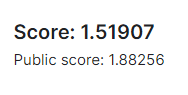